In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
import numpy as np
from sklearn.metrics import make_scorer, f1_score
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from keras import regularizers
from keras.callbacks import EarlyStopping

import random
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


## Load data

In [12]:
df_encoded = pd.read_csv("data/encoded_data.csv", sep="\t")
df = pd.read_csv("data/combined_dataframe_clean.csv", sep="\t")

## Split dataframe

In [13]:
X_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(df_encoded, df['GoodPitStop'], test_size=0.3, random_state=4815)
X_train_HP, X_test_HP, y_train_HP, y_test_HP = train_test_split(df_encoded, df['HasPitLap'], test_size=0.3, random_state=4815)

## Functions

In [23]:
def plot_NNN(name, h, EPOCHS):
    LOSS = 0; F1 = 1
    training = np.zeros((2, EPOCHS))
    testing = np.zeros((2, EPOCHS))
    training[LOSS] = h.history['loss']
    testing[LOSS] = h.history['val_loss']  # validation loss
    training[F1] = h.history['f1_m']
    testing[F1] = h.history['val_f1_m']  # validation accuracy
    epochs = range(1, EPOCHS + 1)
    fig, axs = plt.subplots(1, 2, figsize=(17, 5))
    training_color = "#0072B2"  # Set the color for training
    testing_color = "#009E73"  # Set the color for testing
    axs[LOSS].plot(epochs, training[LOSS], color=training_color, label='Training loss')
    axs[LOSS].plot(epochs, testing[LOSS], color=testing_color, label='Test loss')
    axs[F1].plot(epochs, training[F1], color=training_color, label='Training f1')
    axs[F1].plot(epochs, testing[F1], color=testing_color, label='Test f1')
    for i in range(2):
        axs[i].set_title('Training and test ' + ['loss', 'f1'][i])
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(['loss', 'f1'][i])
        axs[i].legend()
    #plt.savefig("img/results/" + name, dpi=300, bbox_inches='tight')

In [15]:
def remove_null (df): 
    #Qualy Position and GridPosition
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if ( np.isnan(val["QualyPosition"].iloc[0])):
                    df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "QualyPosition"] = val["Position"].iloc[0]
                if ( val["GridPosition"].iloc[0] == 0):
                    df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "GridPosition"] = val["Position"].iloc[0]
    
    #DriverStandings
    df['DriverStandings'] = df['DriverStandings'].fillna(0)

    return df

In [16]:
def f1_m(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Handle Class Imbalance

Class Weights: Adjust the class weights to give more importance to the minority class during training. The class_weight parameter can be passed to the Keras model.

In [17]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_HP), y = y_train_HP)
class_weights_dict = dict(zip(np.unique(y_train_HP), class_weights))
class_weights_dict

{0.0: 0.514641598119859, 1.0: 17.574638844301766}

In [18]:
class_weights_GP = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_GP), y = y_train_GP)
class_weights_dict_GP = dict(zip(np.unique(y_train_GP), class_weights))
class_weights_dict_GP

{0: 0.514641598119859, 1: 17.574638844301766}

In [19]:
import tensorflow as tf

seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

# Has pit

## Best HP

In [20]:
l2_value = 0.0001

model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value), input_shape=(X_train_HP.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [21]:
# Compile and train
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=[f1_m])
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train_HP, y_train_HP,
    validation_data=(X_test_HP, y_test_HP),
    epochs=30, batch_size=256,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/30
172/172 [==============================] - 6s 9ms/step - loss: 0.1965 - f1_m: 0.0034 - val_loss: 0.1218 - val_f1_m: 0.0000e+00
Epoch 2/30
172/172 [==============================] - 1s 5ms/step - loss: 0.1142 - f1_m: 0.0102 - val_loss: 0.1035 - val_f1_m: 0.0139
Epoch 3/30
172/172 [==============================] - 1s 6ms/step - loss: 0.1030 - f1_m: 0.1431 - val_loss: 0.0967 - val_f1_m: 0.1460
Epoch 4/30
172/172 [==============================] - 1s 5ms/step - loss: 0.0969 - f1_m: 0.2495 - val_loss: 0.0922 - val_f1_m: 0.2605
Epoch 5/30
172/172 [==============================] - 1s 7ms/step - loss: 0.0916 - f1_m: 0.3347 - val_loss: 0.0879 - val_f1_m: 0.3507
Epoch 6/30
172/172 [==============================] - 1s 6ms/step - loss: 0.0873 - f1_m: 0.3855 - val_loss: 0.0849 - val_f1_m: 0.4191
Epoch 7/30
172/172 [==============================] - 1s 8ms/step - loss: 0.0839 - f1_m: 0.4170 - val_loss: 0.0828 - val_f1_m: 0.4547
Epoch 8/30
172/172 [==============================] - 3s 1

587/587 [==============================] - 2s 3ms/step
F1 score: 0.58719646799117
Number epoch: 25


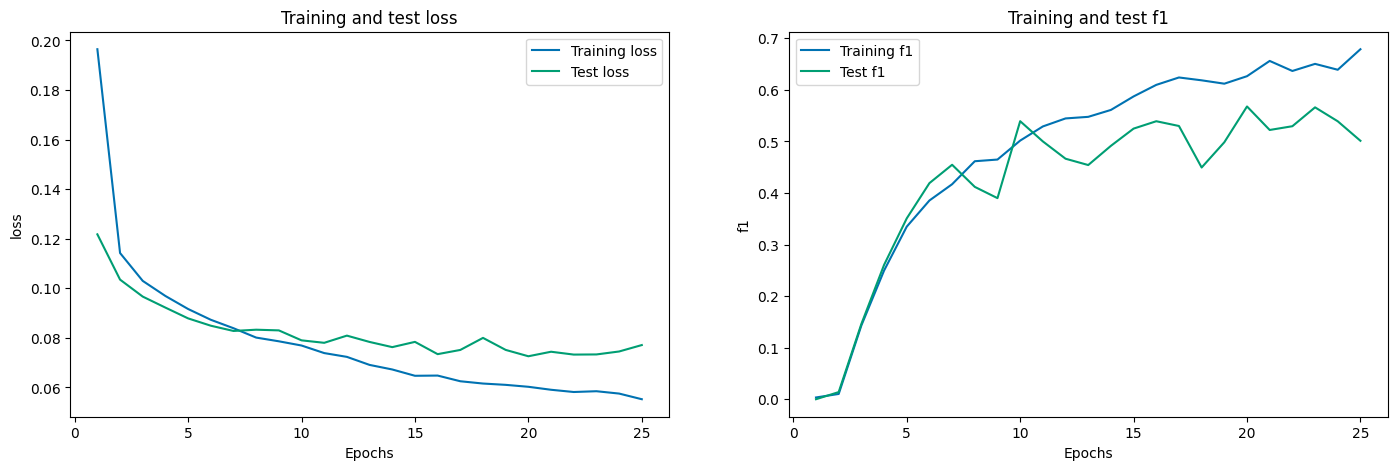

In [24]:
y_pred = model.predict(X_test_HP)
y_pred = np.round(y_pred)
f1 = f1_score(y_test_HP, y_pred)
epoch = len(history.history['loss'])
print('F1 score:', f1)
print('Number epoch:', epoch)
plot_NNN('HP',history, EPOCHS = epoch)

In [25]:
# Calculate training error (Et)
training_loss = model.evaluate(X_train_HP, y_train_HP, verbose=0)
Et = training_loss[0]

# Calculate validation error (Ev)
validation_loss = model.evaluate(X_test_HP, y_test_HP, verbose=0)
Ev = validation_loss[0]

print('Training Error (Et):', Et)
print('Validation Error (Ev):', Ev)

Training Error (Et): 0.047909095883369446
Validation Error (Ev): 0.07258591800928116


F1 score: 0.58719646799117
Number epoch: 25


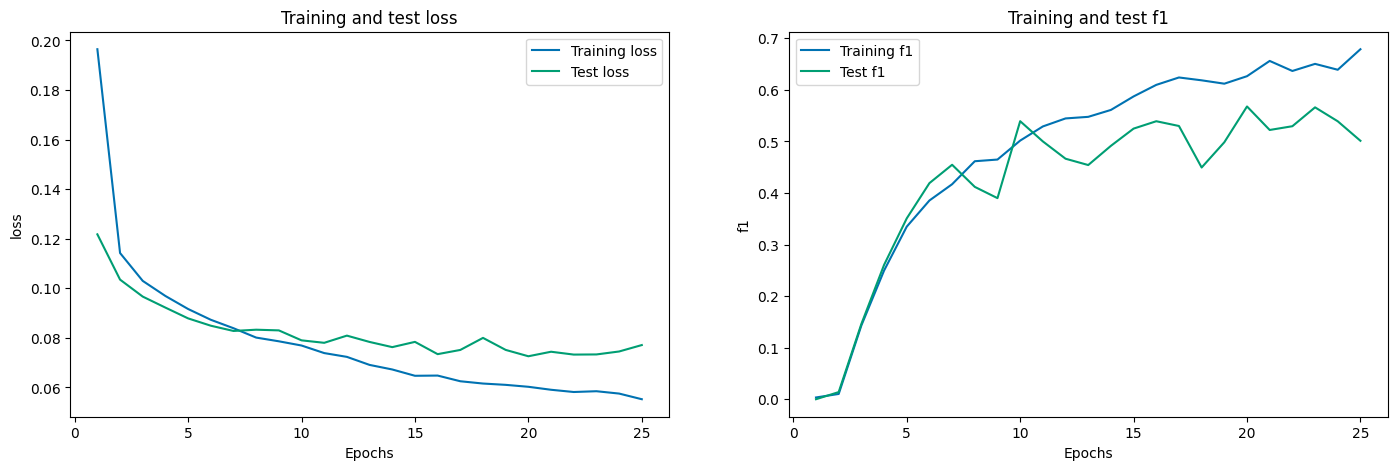

In [26]:
print('F1 score:', f1)
print('Number epoch:', epoch)
plot_NNN('ANN_HP', history, EPOCHS = epoch)

# Good Pit

## Best HP

In [27]:
l2_value = 0.0001

model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value), input_shape=(X_train_GP.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=[f1_m])
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
historyGP = model.fit(
    X_train_GP, y_train_GP,
    validation_data=(X_test_GP, y_test_GP),
    epochs=30, batch_size=256,
    verbose=0,
    callbacks=[early_stopping]
)


In [29]:
# Calculate training error (Et)
training_loss = model.evaluate(X_train_GP, y_train_GP, verbose=0)
Et = training_loss[0]

# Calculate validation error (Ev)
validation_loss = model.evaluate(X_test_GP, y_test_GP, verbose=0)
Ev = validation_loss[0]

print('Training Error (Et):', Et)
print('Validation Error (Ev):', Ev)

Training Error (Et): 0.03436904028058052
Validation Error (Ev): 0.054486729204654694


587/587 [==============================] - 1s 2ms/step
F1 score: 0.288
Number epoch: 27


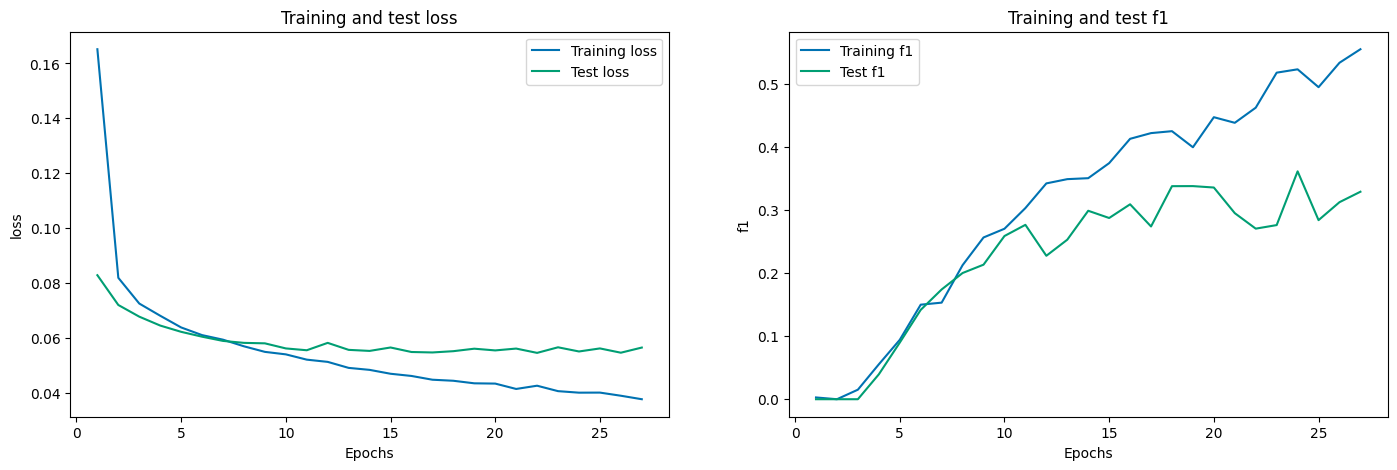

In [30]:
y_predGP = model.predict(X_test_GP)
y_predGP = np.round(y_predGP)
f1_GP = f1_score(y_test_GP, y_predGP)
epoch_GP = len(historyGP.history['loss'])
print('F1 score:', f1_GP)
print('Number epoch:', epoch_GP)
plot_NNN('ANN_GP', historyGP, EPOCHS = epoch_GP)